## LIVER SEGMENTATION MODEL & PREDICTION

Load libs before starting on running with a new instance

In [155]:
!python -m pip install SimpleITK

In [156]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '0cb7a710-8666-42a4-acbd-a3cfba601d29'
resource_group = 'Grup2'
workspace_name = 'Grup2AML'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='liversegmentationdataset')
#dataset.download(target_path='.', overwrite=True)

dataset.to_path()

#COMMENT AFTER DOWNLOAD

['/Ircad/Test/imgs_test.npy',
 '/Ircad/Train/10/imgs_train.npy',
 '/Ircad/Train/10/masks_train.npy',
 '/Ircad/Train/13/imgs_train.npy',
 '/Ircad/Train/13/masks_train.npy',
 '/Ircad/Train/15/imgs_train.npy',
 '/Ircad/Train/15/masks_train.npy',
 '/Test/30_masks_train.npy',
 '/Test/imgs_test.npy',
 '/Train/10/imgs_train.npy',
 '/Train/10/masks_train.npy',
 '/Train/13/imgs_train.npy',
 '/Train/13/masks_train.npy',
 '/Train/15/imgs_train.npy',
 '/Train/15/masks_train.npy',
 '/Train/20/imgs_train.npy',
 '/Train/20/masks_train.npy']

##### IMPORTS

In [157]:
import datetime, json, os, sys

#GRAPHS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#KERAS TRAIN
from keras.models import Model, model_from_json
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, UpSampling2D, Convolution2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras import backend as K

#NIFTI
import SimpleITK as sitk

#PREDICT
from skimage import io
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from skimage.exposure import rescale_intensity

#AZURE LIBS
from io import BytesIO
import requests

### EDIT HERE AT EVERY RUN

Paste signature keys, paths here.

In [158]:
sizeOfBatch = 16
sizeOfEpoch = 20
sizeOfValidation = 0.2

#currentArchitecture = 'NEWTHING - 10E - 16B - 15I'
#currentArchitecture = 'Dense U-Net'
#currentArchitecture = 'ResNet'
currentArchitecture = 'SegNet-Ircad-20-15'

#TRAIN/VAL - #Patient

#2398T/600V - 10
#train_data_path = 'Train/10/imgs_train.npy'
#mask_data_path = 'Train/10/masks_train.npy'

##3508T/877V - 15
train_data_path = 'Ircad/Train/15/imgs_train.npy'
mask_data_path = 'Ircad/Train/15/masks_train.npy'

#IMAGE SIZE - 20
#train_data_path = 'Train/20/imgs_train.npy'
#mask_data_path = 'Train/20/masks_train.npy'

prediction_data_path = 'Test/imgs_test.npy'

#### PATHS

In [159]:
currentDate = datetime.datetime.now().strftime("Trials/%m.%d.%y %H.%M %p " + currentArchitecture + "/")
#currentDate = "Trials/" + "05.17.20 19.41 PM SegNet - 10/"
#currentDate = "Trials/" + "05.18.20 07.56 AM SegNet - 15/"
#currentDate = "Trials/" + "06.10.20 17.38 PM SegNet-Ircad-15-10/"

json_file_path = currentDate +  'JSONFiles/'
graph_file_path = currentDate + 'Graphs/'
nii_save_path = currentDate + 'Outputs/'

if not os.path.exists(json_file_path):
    os.makedirs(json_file_path)
    
if not os.path.exists(graph_file_path):
    os.makedirs(graph_file_path)
    
if not os.path.exists(nii_save_path):
    os.makedirs(nii_save_path)   

In [160]:
#undersample training 2D images later (for memory and speed)
img_rows = int(512/2)
img_cols = int(512/2) 
smooth = 1.
K.set_image_data_format('channels_last')

def load_train_data():
    imgs_train = np.load(train_data_path)
    print("Images for train are added.")
    return imgs_train

def load_mask_data():
    masks_train = np.load(mask_data_path)
    print("Layers for train are added.")
    return masks_train

def load_prediction_images():
    imgst = np.load(prediction_data_path)
    print("Prediction NifTI is loaded.")
    return imgst

In [161]:
def dice_coef(y_true, y_pred):    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)    
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):    
    return -dice_coef(y_true, y_pred)

def preprocess(imgs):    
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)    
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)
    imgs_p = imgs_p[..., np.newaxis]    
    print("File is resized.");
    print('-'*30)
    return imgs_p

#### UNCOMMENT IF YOU USE SEGNET

In [162]:
#FOR SEGNET
def merge(inputs, mode, concat_axis=-1):
    return concatenate(inputs, concat_axis)

### SEGNET

In [163]:
def get_segnet():
    inputs = Input((img_rows, img_cols, 1))

    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv1)

    down1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = BatchNormalization()(down1)
    conv2 = Convolution2D(2 * 16, 3, 3, activation='relu', border_mode='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Convolution2D(2 * 16, 3, 3, activation='relu', border_mode='same')(conv2)

    down2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = BatchNormalization()(down2)
    conv3 = Convolution2D(4 * 16, 3, 3, activation='relu', border_mode='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Convolution2D(4 * 16, 3, 3, activation='relu', border_mode='same')(conv3)

    down3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = BatchNormalization()(down3)
    conv4 = Convolution2D(8 * 16, 3, 3, activation='relu', border_mode='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Convolution2D(8 * 16, 3, 3, activation='relu', border_mode='same')(conv4)

    down4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = BatchNormalization()(down4)
    conv5 = Convolution2D(16 * 16, 3, 3, activation='relu', border_mode='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Convolution2D(16 * 16, 3, 3, activation='relu', border_mode='same')(conv5)

    up1 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)

    conv6 = BatchNormalization()(up1)
    conv6 = Convolution2D(8 * 16, 3, 3, activation='relu', border_mode='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Convolution2D(8 * 16, 3, 3, activation='relu', border_mode='same')(conv6)

    up2 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)

    conv7 = BatchNormalization()(up2)
    conv7 = Convolution2D(4 * 16, 3, 3, activation='relu', border_mode='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Convolution2D(4 * 16, 3, 3, activation='relu', border_mode='same')(conv7)

    up3 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)

    conv8 = BatchNormalization()(up3)
    conv8 = Convolution2D(2 * 16, 3, 3, activation='relu', border_mode='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Convolution2D(2 * 16, 3, 3, activation='relu', border_mode='same')(conv8)

    up4 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)

    conv9 = BatchNormalization()(up4)
    conv9 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv9)

    # --- end first u block

    down1b = MaxPooling2D(pool_size=(2, 2))(conv9)
    down1b = merge([down1b, conv8], mode='concat', concat_axis=3)

    conv2b = BatchNormalization()(down1b)
    conv2b = Convolution2D(2 * 16, 3, 3, activation='relu', border_mode='same')(conv2b)
    conv2b = BatchNormalization()(conv2b)
    conv2b = Convolution2D(2 * 16, 3, 3, activation='relu', border_mode='same')(conv2b)

    down2b = MaxPooling2D(pool_size=(2, 2))(conv2b)
    down2b = merge([down2b, conv7], mode='concat', concat_axis=3)

    conv3b = BatchNormalization()(down2b)
    conv3b = Convolution2D(4 * 16, 3, 3, activation='relu', border_mode='same')(conv3b)
    conv3b = BatchNormalization()(conv3b)
    conv3b = Convolution2D(4 * 16, 3, 3, activation='relu', border_mode='same')(conv3b)

    down3b = MaxPooling2D(pool_size=(2, 2))(conv3b)
    down3b = merge([down3b, conv6], mode='concat', concat_axis=3)

    conv4b = BatchNormalization()(down3b)
    conv4b = Convolution2D(8 * 16, 3, 3, activation='relu', border_mode='same')(conv4b)
    conv4b = BatchNormalization()(conv4b)
    conv4b = Convolution2D(8 * 16, 3, 3, activation='relu', border_mode='same')(conv4b)

    down4b = MaxPooling2D(pool_size=(2, 2))(conv4b)
    down4b = merge([down4b, conv5], mode='concat', concat_axis=3)

    conv5b = BatchNormalization()(down4b)
    conv5b = Convolution2D(16 * 16, 3, 3, activation='relu', border_mode='same')(conv5b)
    conv5b = BatchNormalization()(conv5b)
    conv5b = Convolution2D(16 * 16, 3, 3, activation='relu', border_mode='same')(conv5b)

    up1b = merge([UpSampling2D(size=(2, 2))(conv5b), conv4b], mode='concat', concat_axis=3)

    conv6b = BatchNormalization()(up1b)
    conv6b = Convolution2D(8 * 16, 3, 3, activation='relu', border_mode='same')(conv6b)
    conv6b = BatchNormalization()(conv6b)
    conv6b = Convolution2D(8 * 16, 3, 3, activation='relu', border_mode='same')(conv6b)

    up2b = merge([UpSampling2D(size=(2, 2))(conv6b), conv3b], mode='concat', concat_axis=3)

    conv7b = BatchNormalization()(up2b)
    conv7b = Convolution2D(4 * 16, 3, 3, activation='relu', border_mode='same')(conv7b)
    conv7b = BatchNormalization()(conv7b)
    conv7b = Convolution2D(4 * 16, 3, 3, activation='relu', border_mode='same')(conv7b)

    up3b = merge([UpSampling2D(size=(2, 2))(conv7b), conv2b], mode='concat', concat_axis=3)

    conv8b = BatchNormalization()(up3b)
    conv8b = Convolution2D(2 * 16, 3, 3, activation='relu', border_mode='same')(conv8b)
    conv8b = BatchNormalization()(conv8b)
    conv8b = Convolution2D(2 * 16, 3, 3, activation='relu', border_mode='same')(conv8b)

    up4b = merge([UpSampling2D(size=(2, 2))(conv8b), conv9], mode='concat', concat_axis=3)

    conv9b = BatchNormalization()(up4b)
    conv9b = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv9b)
    conv9b = BatchNormalization()(conv9b)
    conv9b = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv9b)
    conv9b = BatchNormalization()(conv9b)

    outputs = Convolution2D(1, 1, 1, activation='hard_sigmoid', border_mode='same')(conv9b)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef, 'acc'])
    model.summary()

    return model

### CLASSIC U-NET

In [164]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    model.summary()
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef, 'acc'])
    
    return model

### DENSE U-NET

In [165]:
def get_denseunet():
    
    inputs = Input((img_rows, img_cols, 1))
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conc11 = concatenate([inputs, conv11], axis=3)
    conv12 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc11)
    conc12 = concatenate([inputs, conv12], axis=3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conc12)

    conv21 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conc21 = concatenate([pool1, conv21], axis=3)
    conv22 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc21)
    conc22 = concatenate([pool1, conv22], axis=3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conc22)

    conv31 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conc31 = concatenate([pool2, conv31], axis=3)
    conv32 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc31)
    conc32 = concatenate([pool2, conv32], axis=3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conc32)

    conv41 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conc41 = concatenate([pool3, conv41], axis=3)
    conv42 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc41)
    conc42 = concatenate([pool3, conv42], axis=3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conc42)

    conv51 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conc51 = concatenate([pool4, conv51], axis=3)
    conv52 = Conv2D(512, (3, 3), activation='relu', padding='same')(conc51)
    conc52 = concatenate([pool4, conv52], axis=3)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conc52), conc42], axis=3)
    conv61 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conc61 = concatenate([up6, conv61], axis=3)
    conv62 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc61)
    conc62 = concatenate([up6, conv62], axis=3)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conc62), conv32], axis=3)
    conv71 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conc71 = concatenate([up7, conv71], axis=3)
    conv72 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc71)
    conc72 = concatenate([up7, conv72], axis=3)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conc72), conv22], axis=3)
    conv81 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conc81 = concatenate([up8, conv81], axis=3)
    conv82 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc81)
    conc82 = concatenate([up8, conv82], axis=3)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conc82), conv12], axis=3)
    conv91 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conc91 = concatenate([up9, conv91], axis=3)
    conv92 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc91)
    conc92 = concatenate([up9, conv92], axis=3)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conc92)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef, 'acc'])
    model.summary()
    return model

### RESNET

In [166]:
def get_resnet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conc1 = concatenate([inputs, conv1], axis=3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conc1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conc2 = concatenate([pool1, conv2], axis=3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conc2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conc3 = concatenate([pool2, conv3], axis=3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conc3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conc4 = concatenate([pool3, conv4], axis=3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conc4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conc5 = concatenate([pool4, conv5], axis=3)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conc5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conc6 = concatenate([up6, conv6], axis=3)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conc6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conc7 = concatenate([up7, conv7], axis=3)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conc7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conc8 = concatenate([up8, conv8], axis=3)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conc8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conc9 = concatenate([up9, conv9], axis=3)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conc9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.summary()
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef, 'acc'])

    return model

## UNCOMMENT ARCHITECTURE YOU WANT TO USE

In [167]:
import keras
# or from tensorflow import keras

keras.backend.set_image_data_format('channels_last')
# or keras.backend.set_image_data_format('channels_first')

def train():
    
    print('Getting model...')
    print('-'*30)
    
    #Call Neural Network
    #model = get_unet()
    #model = get_denseunet()
    #model = get_resunet()
    model = get_segnet()
    
    
    print('Loading and preprocessing train data...')
    print('-'*30)
    
    imgs_train = load_train_data()
    imgs_mask_train = load_mask_data()
    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    print('Normalization of the Train Set')
    print('-'*30)
    
    imgs_train = imgs_train.astype('float32')
    
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std      
    
    imgs_mask_train = imgs_mask_train.astype('float32')

    print('Creating and compiling model...')
    print('-'*30)
    
    #Save model weights
    model_checkpoint = ModelCheckpoint(currentDate + 'weights.h5', monitor='val_loss', save_best_only=True)
    
    print('Saving the weights and the loss of the best predictions')
    print('-'*30)
    
    print('Fitting model...')
    print('-'*30)
    
    history=model.fit(imgs_train, imgs_mask_train, batch_size=sizeOfBatch, epochs=sizeOfEpoch, verbose=1, 
                      shuffle=True, validation_split=sizeOfValidation, callbacks=[model_checkpoint])
        
    #Save Normalization Data to the JSON file
    normalization = '{"mean": ' + str(mean) + ', "std": ' + str(std) + '}'
    
    with open(json_file_path + "normalization.json", "w") as json_file:
        json_file.write(str(normalization))
    
    print("Normalization data is saved to the disk")
    print('-'*30)
    
    #Save Model to the JSON file
    model_json = model.to_json()
    
    with open(json_file_path + "model.json", "w") as json_file:
        json_file.write(model_json)
        
    print("Model is saved to disk")
    print('-'*30)
    
    #Save History to the JSON file    
    hist_df = pd.DataFrame(history.history) 
    
    with open(json_file_path + 'history.json' , mode='w') as f:
        hist_df.to_json(f)
              
    print("History is saved to disk")   
    print('-'*30)    

In [168]:
def graphs():
    
    #this function creates graphs from records in history.json    
    historyFile = open(json_file_path + 'history.json', 'r')
    historyString = historyFile.read()
    history = json.loads(historyString)
    historyFile.close()
    
    #number of epochs
    size_acc = len(history["acc"])
    size_val_acc = len(history["val_acc"])
    size_dice_coef = len(history["dice_coef"])
    size_val_dice_coef = len(history["val_dice_coef"])
    size_loss = len(history["loss"])
    size_val_loss = len(history["val_loss"])
    
    history_acc = []
    history_val_acc = []
    history_dice_coef = []
    history_val_dice_coef = []
    history_loss = []
    history_val_loss = []
    
    for i in range(0,size_acc):
        history_acc.append(history["acc"]["{}".format(i)])
    
    for i in range(0,size_val_acc):
        history_val_acc.append(history["val_acc"]["{}".format(i)])

    for i in range(0,size_dice_coef):
        history_dice_coef.append(history["dice_coef"]["{}".format(i)])
    
    for i in range(0,size_val_dice_coef):
        history_val_dice_coef.append(history["val_dice_coef"]["{}".format(i)])
        
    for i in range(0,size_loss):
        history_loss.append(history["loss"]["{}".format(i)])
    
    for i in range(0,size_val_loss):
        history_val_loss.append(history["val_loss"]["{}".format(i)])

    if not os.path.exists(graph_file_path):
        os.mkdir(graph_file_path)   
        
    print('Dice Coeff results in function of the number of epochs')   
    plt.plot(history_dice_coef)
    plt.plot(history_val_dice_coef)
    plt.title('Model Dice Coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    dice_coeff_graph = plt.gcf()
    dice_coeff_graph.savefig(os.path.join(graph_file_path) + 'dice_coeff_graph.png')
    plt.show()

    print('Summarize history for loss')
    plt.plot(history_loss)
    plt.plot(history_val_loss)
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    loss_graph = plt.gcf()
    loss_graph.savefig(os.path.join(graph_file_path) + 'loss_graph.png')
    plt.show()
    
    print('Summarize history for accuracy')  
    plt.plot(history_acc)
    plt.plot(history_val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('acc')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    acc_graph = plt.gcf()
    acc_graph.savefig(os.path.join(graph_file_path) + 'acc_graph.png')
    plt.show()

In [169]:
def predict():
    normalizationFile = open(json_file_path + 'normalization.json', 'r')
    normalizationString = normalizationFile.read()
    normalizationData = json.loads(normalizationString)
    normalizationFile.close()
    
    #Load Model
    jsonFile = open( json_file_path + 'model.json', 'r')
    loadedModelJson = jsonFile.read()
    model = model_from_json(loadedModelJson)
    jsonFile.close()
    
    #model.summary()
    
    imgToPredict = load_prediction_images()
    imgToPredict = preprocess(imgToPredict)
    
    mean = normalizationData["mean"]
    std = normalizationData["std"]
    
    imgToPredict = imgToPredict.astype('float32')
    imgToPredict -= mean
    imgToPredict /= std

    print("Load weights.h5 file: ")
    model_data_path = currentDate + "weights.h5"
    print(model_data_path + " is weights.h5 path")
    print('-'*30)
    
    model.load_weights(model_data_path)
    
    print("Model is loaded.")
    print('-'*30)
    
    predictedImageAsNumpy = model.predict(imgToPredict, verbose=1)
    print("Prediction is completed.")
    print('-'*30)
    
    print("Exporting predictions...")
    print('-'*30)
    new_images = [] 
    imgst = np.ndarray((img_rows, img_cols, 0), dtype='float32')
    layerst = np.ndarray((img_rows, img_cols, 0), dtype='float32')

    print("Slices are being adapted...")
    for k in range(len(predictedImageAsNumpy)):
        a=rescale_intensity(imgToPredict[k][:,:,0],out_range=(-1,1))
        b=(predictedImageAsNumpy[k][:,:,0]).astype('uint8')
        imgst = np.dstack((imgst, a))
        layerst = np.dstack((layerst, b))
    print("Slices are adapted.")
    print('-'*30)
    
    nifti_format(imgst,layerst)

In [170]:
def nifti_format(imgst, layerst):
    
    print("Exporting...")            
    filtered_image = sitk.GetImageFromArray(imgst)
    writer = sitk.ImageFileWriter()
    writer.SetFileName(nii_save_path +"Liver.nii.gz")
    writer.Execute(filtered_image)
    
    filtered_mask = sitk.GetImageFromArray(layerst)
    writer = sitk.ImageFileWriter()
    writer.SetFileName(nii_save_path + "Layer.nii.gz")
    writer.Execute(filtered_mask)
    print("Exporting is completed.")
    
    fig = plt.figure(figsize=(50, 50))
    s = []
    z = 125
    while(z > 124):
        s.append(sitk.GetArrayViewFromImage(filtered_mask)[z,:,:])
        z -=1
    z = 125
    while(z > 124):
        s.append(sitk.GetArrayViewFromImage(filtered_image)[z,:,:])
        z -=1
    print(len(s))
    for i in range(2):    
        sub = fig.add_subplot(1,2, i + 1)
        sub.imshow(s[i], interpolation='nearest')
    print('-'*30)

In [171]:
"""import scipy.misc
arr = np.load("Test/30_masks_train.npy")
plt.imshow(sitk.GetArrayViewFromImage(filtered_image)[124,:,:], interpolation='nearest')
plt.show()"""

'import scipy.misc\narr = np.load("Test/30_masks_train.npy")\nplt.imshow(sitk.GetArrayViewFromImage(filtered_image)[124,:,:], interpolation=\'nearest\')\nplt.show()'

# COMMENT/UNCOMMENT FUNCTIONS

Getting model...
------------------------------


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same")`
  after removing the cwd from sys.path.
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same")`
  
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: 

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 256, 256, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 256, 256, 16) 64          conv2d_106[0][0]                 
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 256, 256, 16) 2320        batch_normalization_103[0][0]    
____________________________________________________________________________________________

Images for train are added.
Layers for train are added.
File is resized.
------------------------------
File is resized.
------------------------------
Normalization of the Train Set
------------------------------
Creating and compiling model...
------------------------------
Saving the weights and the loss of the best predictions
------------------------------
Fitting model...
------------------------------
Train on 1700 samples, validate on 426 samples
Epoch 1/20
1700/1700 [==============================] - 532s 313ms/step - loss: -0.5054 - dice_coef: 0.5067 - acc: 0.8964 - val_loss: -0.0992 - val_dice_coef: 0.0980 - val_acc: 0.0553
Epoch 2/20
1700/1700 [==============================] - 527s 310ms/step - loss: -0.8062 - dice_coef: 0.8064 - acc: 0.9809 - val_loss: -0.0994 - val_dice_coef: 0.0982 - val_acc: 0.0573
Epoch 3/20
1700/1700 [==============================] - 523s 308ms/step - loss: -0.8683 - dice_coef: 0.8682 - acc: 0.9874 - val_loss: -0.2119 - val_dice_coef: 0.2095 - val_a

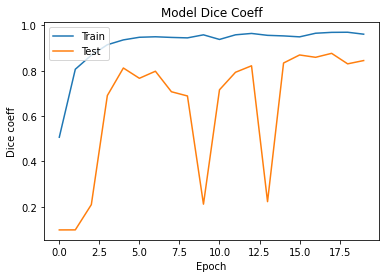

Summarize history for loss


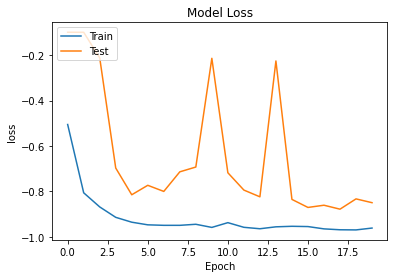

Summarize history for accuracy


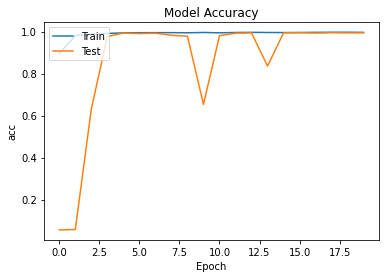

Prediction NifTI is loaded.
File is resized.
------------------------------
Load weights.h5 file: 
Trials/06.10.20 22.51 PM SegNet-Ircad-20-15/weights.h5 is weights.h5 path
------------------------------
Model is loaded.
------------------------------
245/245 [==============================] - 11s 47ms/step
Prediction is completed.
------------------------------
Exporting predictions...
------------------------------
Slices are being adapted...
Slices are adapted.
------------------------------
Exporting...
Exporting is completed.
2
------------------------------
DONE


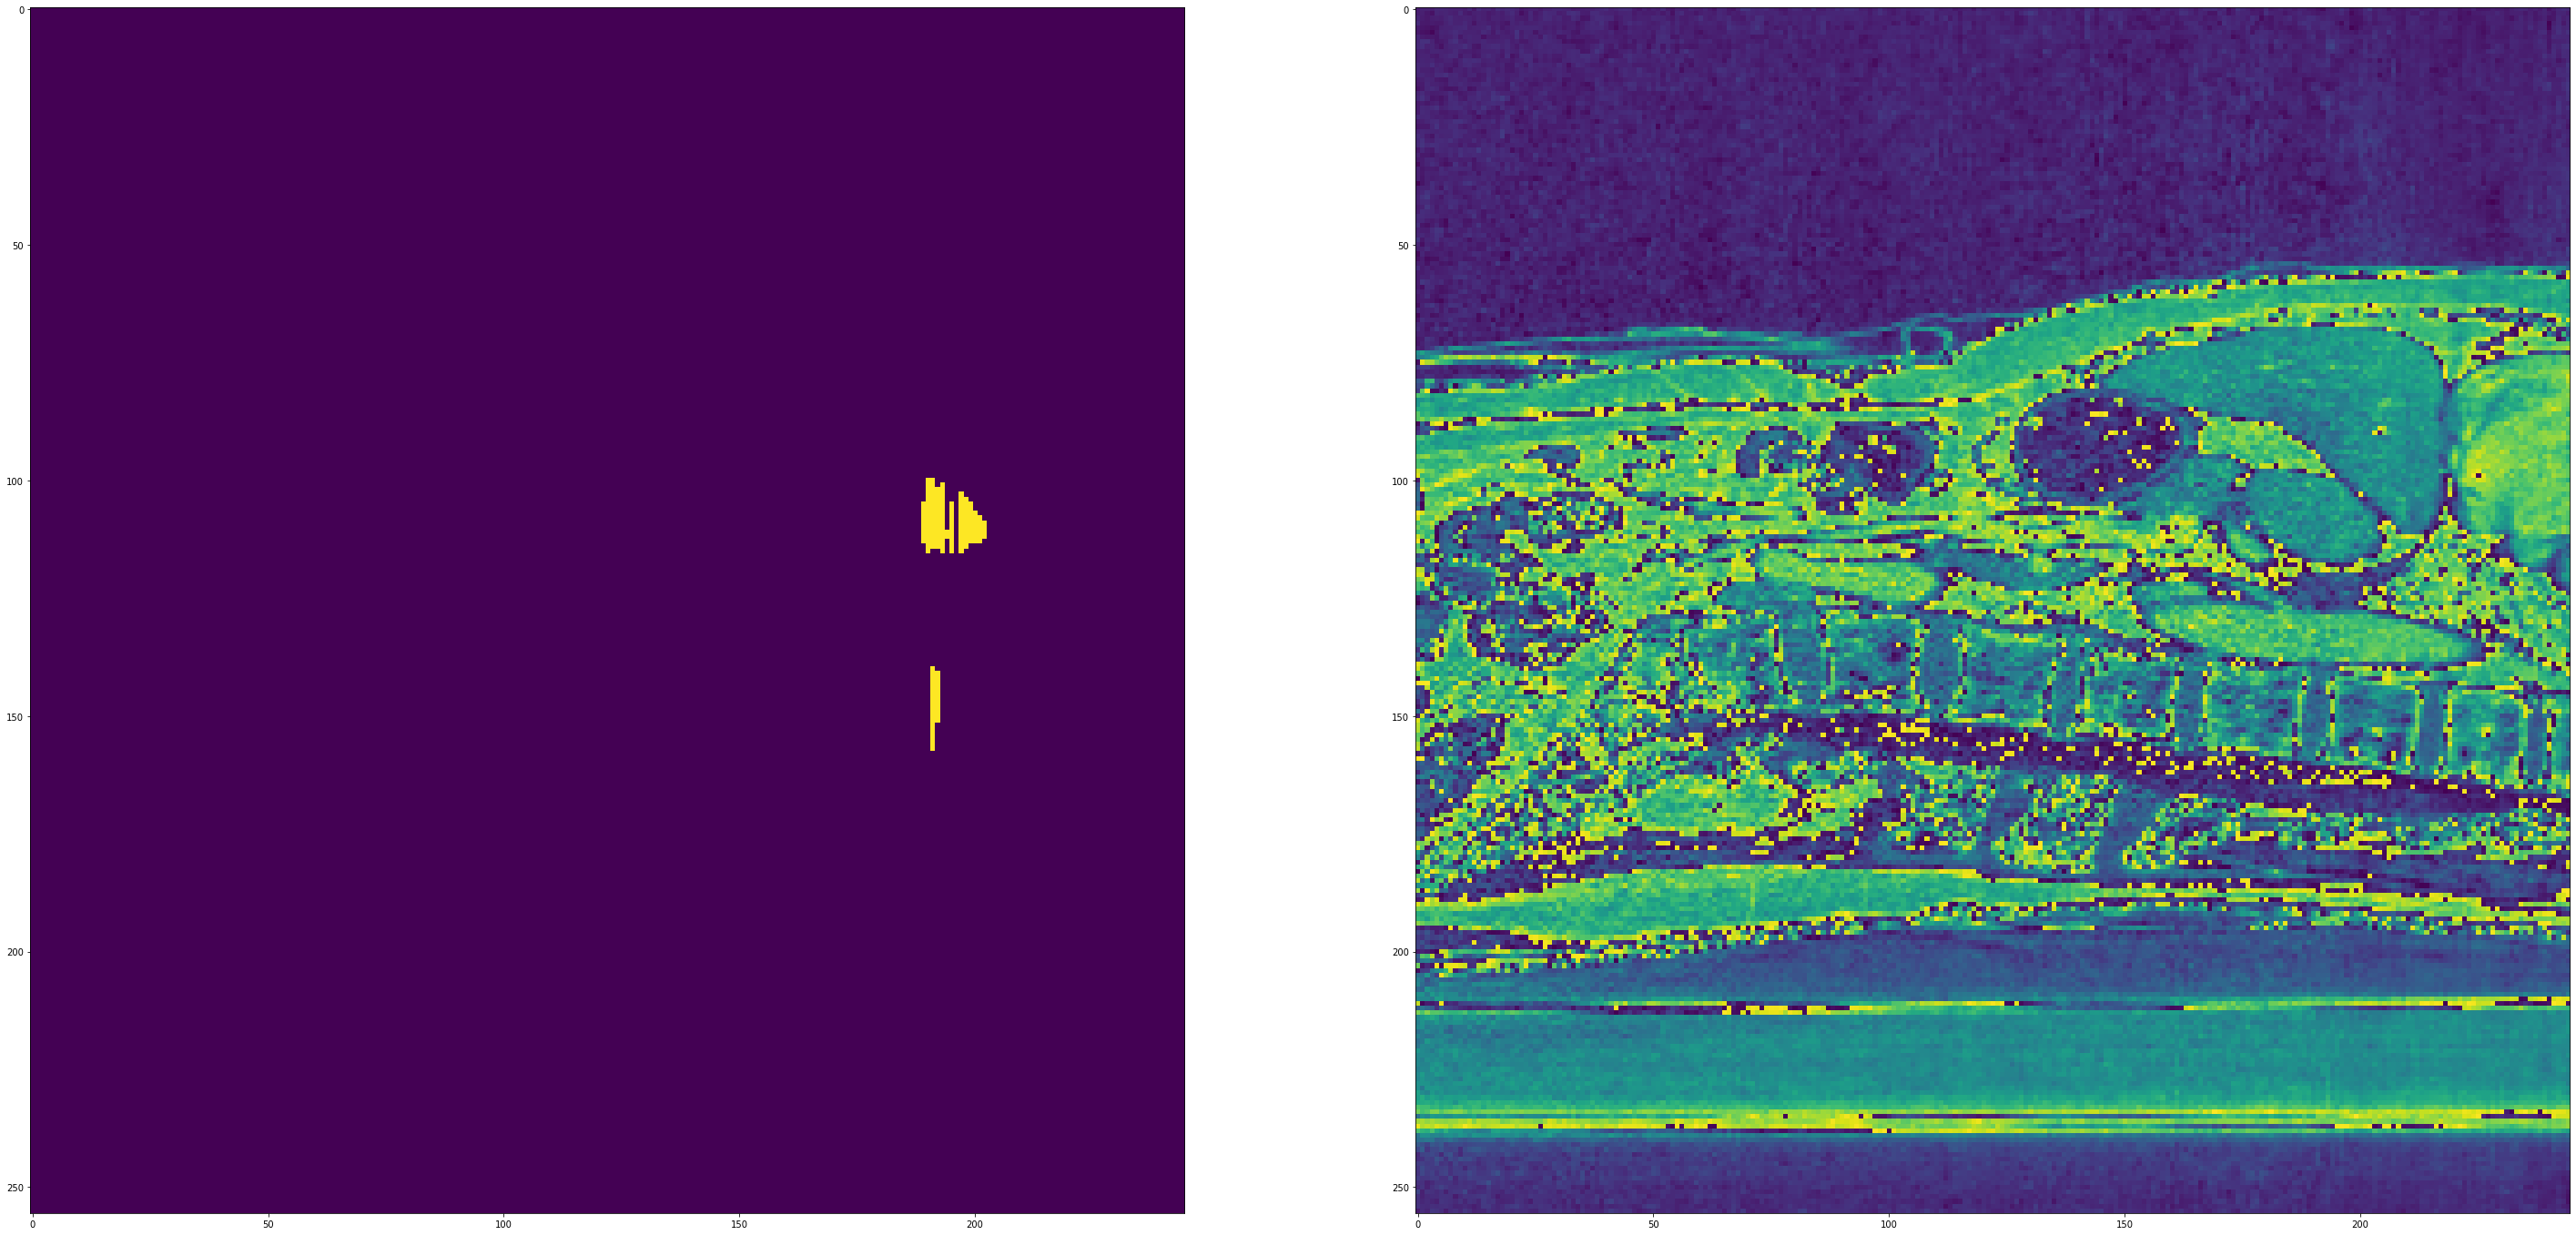

In [172]:
if __name__ == '__main__':
    train()
    graphs()
    predict()
    print("DONE")

In [173]:
"""import glob

files = glob.glob(currentDate + 'Outputs/*')
for f in files:
    os.remove(f)"""

"import glob\n\nfiles = glob.glob(currentDate + 'Outputs/*')\nfor f in files:\n    os.remove(f)"

In [174]:
#!pip install -U segmentation-models